In [12]:
import stlearn as st
from pathlib import Path
st.settings.set_figure_params(dpi=180)

from torchvision.models import resnet50, ResNet50_Weights
import torch

import umap
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA


/home/philipp/miniconda3/envs/stlearn/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/philipp/miniconda3/envs/stlearn/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/philipp/miniconda3/envs/stlearn/lib/python3.8/site-packages/

In [2]:

import scanpy as sc
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
import json

from PIL import Image

#current_folder = Path(__file__).parent
current_folder = globals()['_dh'][0]
image_dir = current_folder / ".." / ".." / "data" / "raw" / "visium"
processed_dir = current_folder / ".." / ".." / "data" / "uscsc_dump" 

# tmp paths
TILE_PATH = current_folder / ".." / ".." / "data" / "tmp" / "tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)
OUT_PATH = current_folder / ".." / ".." / "data" / "tmp" / "out"
OUT_PATH.mkdir(parents=True, exist_ok=True)

In [3]:
from pathlib import Path, PurePath
from typing import Optional, Union
from anndata import AnnData
import numpy as np
from PIL import Image
import pandas as pd
import stlearn
import scanpy
import scipy
import matplotlib.pyplot as plt
from matplotlib.image import imread
import json

_background = ["black", "white"]

def Read10X(
    path,
    genome = None,
    count_file = "filtered_feature_bc_matrix.h5",
    library_id = None,
    load_images = True,
    quality = "hires",
    image_path = None) -> AnnData:
    """
    Read Visium data from 10X (wrap read_visium from scanpy)

    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.

    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview

    Parameters
    ----------
    path
        Path to directory for visium datafiles.
    genome
        Filter expression to genes within this genome.
    count_file
        Which file in the passed directory to use as the count file. Typically would be one of:
        'filtered_feature_bc_matrix.h5' or 'raw_feature_bc_matrix.h5'.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    load_images
        Load image or not.
    quality
        Set quality that convert to stlearn to use. Store in anndata.obs['imagecol' & 'imagerow']
    image_path
        Path to image. Only need when loading full resolution image.


    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'fulres'`, `'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """

    path = Path(path)
    adata = scanpy.read_10x_h5(path / count_file, genome=genome)

    adata.uns["spatial"] = dict()

    from h5py import File

    with File(path / count_file, mode="r") as f:
        attrs = dict(f.attrs)
    if library_id is None:
        library_id = str(attrs.pop("library_ids")[0], "utf-8")

    adata.uns["spatial"][library_id] = dict()

    tissue_positions_file = (
        path / "spatial/tissue_positions.csv"
        if (path / "spatial/tissue_positions.csv").exists()
        else path / "spatial/tissue_positions_list.csv"
    )

    if load_images:
        files = dict(
            tissue_positions_file=tissue_positions_file,
            scalefactors_json_file=path / "spatial/scalefactors_json.json",
            hires_image=path / "spatial/tissue_hires_image.png",
            lowres_image=path / "spatial/tissue_lowres_image.png",
        )

        # check if files exists, continue if images are missing
        for f in files.values():
            if not f.exists():
                if any(x in str(f) for x in ["hires_image", "lowres_image"]):
                    logg.warning(
                        f"You seem to be missing an image file.\n"
                        f"Could not find '{f}'."
                    )
                else:
                    raise OSError(f"Could not find '{f}'")

        adata.uns["spatial"][library_id]["images"] = dict()
        for res in ["hires", "lowres"]:
            try:
                adata.uns["spatial"][library_id]["images"][res] = imread(
                    str(files[f"{res}_image"])
                )
            except Exception:
                raise OSError(f"Could not find '{res}_image'")

        # read json scalefactors
        adata.uns["spatial"][library_id]["scalefactors"] = json.loads(
            files["scalefactors_json_file"].read_bytes()
        )

        adata.uns["spatial"][library_id]["metadata"] = {
            k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
            for k in ("chemistry_description", "software_version")
            if k in attrs
        }

        # read coordinates
        positions = pd.read_csv(files["tissue_positions_file"], header=None)
        positions.columns = [
            "barcode",
            "in_tissue",
            "array_row",
            "array_col",
            "pxl_col_in_fullres",
            "pxl_row_in_fullres",
        ]
        positions.index = positions["barcode"]

        adata.obs = adata.obs.join(positions, how="left")

        adata.obsm["spatial"] = (
            adata.obs[["pxl_row_in_fullres", "pxl_col_in_fullres"]]
            .to_numpy()
            .astype(int)
        )
        adata.obs.drop(
            columns=["barcode", "pxl_row_in_fullres", "pxl_col_in_fullres"],
            inplace=True,
        )

        # put image path in uns
        if image_path is not None:
            # get an absolute path
            image_path = str(Path(image_path).resolve())
            adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
                image_path
            )

    adata.var_names_make_unique()

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    if quality == "fulres":
        image_coor = adata.obsm["spatial"]
        img = plt.imread(image_path, 0)
        adata.uns["spatial"][library_id]["images"]["fulres"] = img
    else:
        scale = adata.uns["spatial"][library_id]["scalefactors"][
            "tissue_" + quality + "_scalef"
        ]
        image_coor = adata.obsm["spatial"] * scale

    adata.obs["imagecol"] = image_coor[:, 0]
    adata.obs["imagerow"] = image_coor[:, 1]
    adata.uns["spatial"][library_id]["use_quality"] = quality

    adata.obs["array_row"] = adata.obs["array_row"].astype(int)
    adata.obs["array_col"] = adata.obs["array_col"].astype(int)
    adata.obsm["spatial"] = adata.obsm["spatial"].astype("int64")

    return adata

In [4]:
samples = [sample for sample in os.listdir(image_dir) if not sample.startswith(".")]
samples

['MS197D',
 'MS411',
 'MS466',
 'MS197U',
 'MS229',
 'MS497T',
 'CO96',
 'CO74',
 'MS371',
 'MS377I',
 'MS377T',
 'MS549T',
 'MS497I',
 'CO85',
 'MS94',
 'CO40',
 'MS549H']

In [5]:
adata = sc.read_h5ad(processed_dir / ("visium_" + samples[0] + ".h5ad"))

In [6]:
data = Read10X(image_dir / samples[0] / "outs")
data

/home/philipp/miniconda3/envs/stlearn/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 2880 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'imagecol', 'imagerow'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [7]:
data.obs

,in_tissue,array_row,array_col,imagecol,imagerow
AAACACCAATAACTGC-1,1,59,19,615.504352,1493.150670
AAACAGCTTTCAGAAG-1,1,43,9,939.912818,1591.220407
AAACAGGGTCTATATT-1,1,47,13,858.032370,1549.501853
AAACAGTGTTCCTGGG-1,1,73,43,322.540470,1233.188032
AAACATTTCCCGGATT-1,1,61,97,529.576582,602.739720
...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,621.731003,1229.140710
TTGTTTCATTAGTCTA-1,1,60,30,589.041090,1368.306338
TTGTTTCCATACAACT-1,1,45,27,889.476953,1387.297620
TTGTTTGTATTACACG-1,1,73,41,323.785800,1255.915305


In [8]:
# pre-processing for gene count table
st.pp.filter_genes(data,min_cells=1)
st.pp.normalize_total(data)
st.pp.log1p(data)

Normalization step is finished in adata.X
Log transformation step is finished in adata.X


In [9]:
# pre-processing for spot image
st.pp.tiling(data, TILE_PATH)

Tiling image: 100%|██████████ [ time left: 00:00 ]


In [13]:
# not use the GPU (because I temporarily lack GPU memory)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# this step uses deep learning model to extract high-level features from tile images
st.pp.extract_feature(data)

2023-05-30 13:50:06.535468: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-30 13:50:07.143031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-30 13:50:07.542656: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-30 13:50:07.542705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: CrunchyPeanut
2023-05-30 13:50:07.542710: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: CrunchyPeanut
2023-05-30 13:50:07.542825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] li

The morphology feature is added to adata.obsm['X_morphology']!


In [15]:
data.obsm["X_morphology"].shape

(2880, 50)

In [16]:
# make umap from data.obsm["X_morphology"].shape
import umap
import matplotlib.pyplot as plt
import seaborn as sns

reducer = umap.UMAP()
embedding = reducer.fit_transform(data.obsm["X_morphology"])

/home/philipp/miniconda3/envs/stlearn/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/philipp/miniconda3/envs/stlearn/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/philipp/miniconda3/envs/stlearn/lib/python3.8/site-packages/

In [39]:
from tensorflow.keras.applications.resnet50 import preprocess_input as keras_preprocess_input

tile_path = data.obs.tile_path[0]
tile = Image.open(tile_path)
tile = np.asarray(tile, dtype="int32")
tile = tile.astype(np.float32)
tile = np.stack([tile])
x = tile
x = x.transpose(0, 3, 1, 2)
x = keras_preprocess_input(x.astype(np.float32))
x = torch.from_numpy(np.flip(x ,axis=0).copy())

In [40]:
from tensorflow.keras.applications.resnet50 import preprocess_input as keras_preprocess_input

model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
#model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.fc = torch.nn.Identity()  # remove last layer

#What I use my pipeline?
# TODO: I am not sure whether I am reading in the images in the correct way
# See here: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
transform = ResNet50_Weights.IMAGENET1K_V2.transforms()
features = np.zeros((len(data), 2048))
#for i, img_name in enumerate(imgs):
for i, tile_path in enumerate(data.obs.tile_path):
    img_path = tile_path

    

    # see here: https://github.com/BiomedicalMachineLearning/stLearn/blob/09c8d7a79979268fe78273fcb25726c5e94c2c6c/stlearn/image_preprocessing/feature_extractor.py#L60
    # and here: https://github.com/BiomedicalMachineLearning/stLearn/blob/09c8d7a79979268fe78273fcb25726c5e94c2c6c/stlearn/image_preprocessing/model_zoo.py#LL54C12-L54C12
    # we need to make sure to use the same transforms as in the original training
    #img = Image.open(img_path)
    #img = transform(img)
    #img = img.unsqueeze(0)

    tile_path = data.obs.tile_path[0]
    tile = Image.open(tile_path)
    tile = np.asarray(tile, dtype="int32")
    tile = tile.astype(np.float32)
    tile = np.stack([tile])
    tile = tile.transpose(0, 3, 1, 2)
    tile = keras_preprocess_input(tile)
    img = torch.from_numpy(np.flip(tile ,axis=0).copy())

    features[i, :] = model.forward(img).detach().numpy()

KeyboardInterrupt: 

In [13]:
print(features.shape)
# make pca of the features
pca_coords = PCA(n_components=50).fit_transform(features)

reducer = umap.UMAP()
embedding_2 = reducer.fit_transform(pca_coords)

In [14]:
# join adata.obs.loc[:, ["leiden"]] to data.obs
data.obs = data.obs.join(adata.obs.loc[:, ["leiden"]], how="left")
data.obs

,in_tissue,array_row,array_col,imagecol,imagerow,tile_path,leiden
AAACACCAATAACTGC-1,1,59,19,615.504352,1493.150670,/home/philipp/Work/VisiumMS/scripts/process/.....,5
AAACAGCTTTCAGAAG-1,1,43,9,939.912818,1591.220407,/home/philipp/Work/VisiumMS/scripts/process/.....,5
AAACAGGGTCTATATT-1,1,47,13,858.032370,1549.501853,/home/philipp/Work/VisiumMS/scripts/process/.....,5
AAACAGTGTTCCTGGG-1,1,73,43,322.540470,1233.188032,/home/philipp/Work/VisiumMS/scripts/process/.....,2
AAACATTTCCCGGATT-1,1,61,97,529.576582,602.739720,/home/philipp/Work/VisiumMS/scripts/process/.....,3
...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,621.731003,1229.140710,/home/philipp/Work/VisiumMS/scripts/process/.....,6
TTGTTTCATTAGTCTA-1,1,60,30,589.041090,1368.306338,/home/philipp/Work/VisiumMS/scripts/process/.....,4
TTGTTTCCATACAACT-1,1,45,27,889.476953,1387.297620,/home/philipp/Work/VisiumMS/scripts/process/.....,6
TTGTTTGTATTACACG-1,1,73,41,323.785800,1255.915305,/home/philipp/Work/VisiumMS/scripts/process/.....,2


<Axes: >

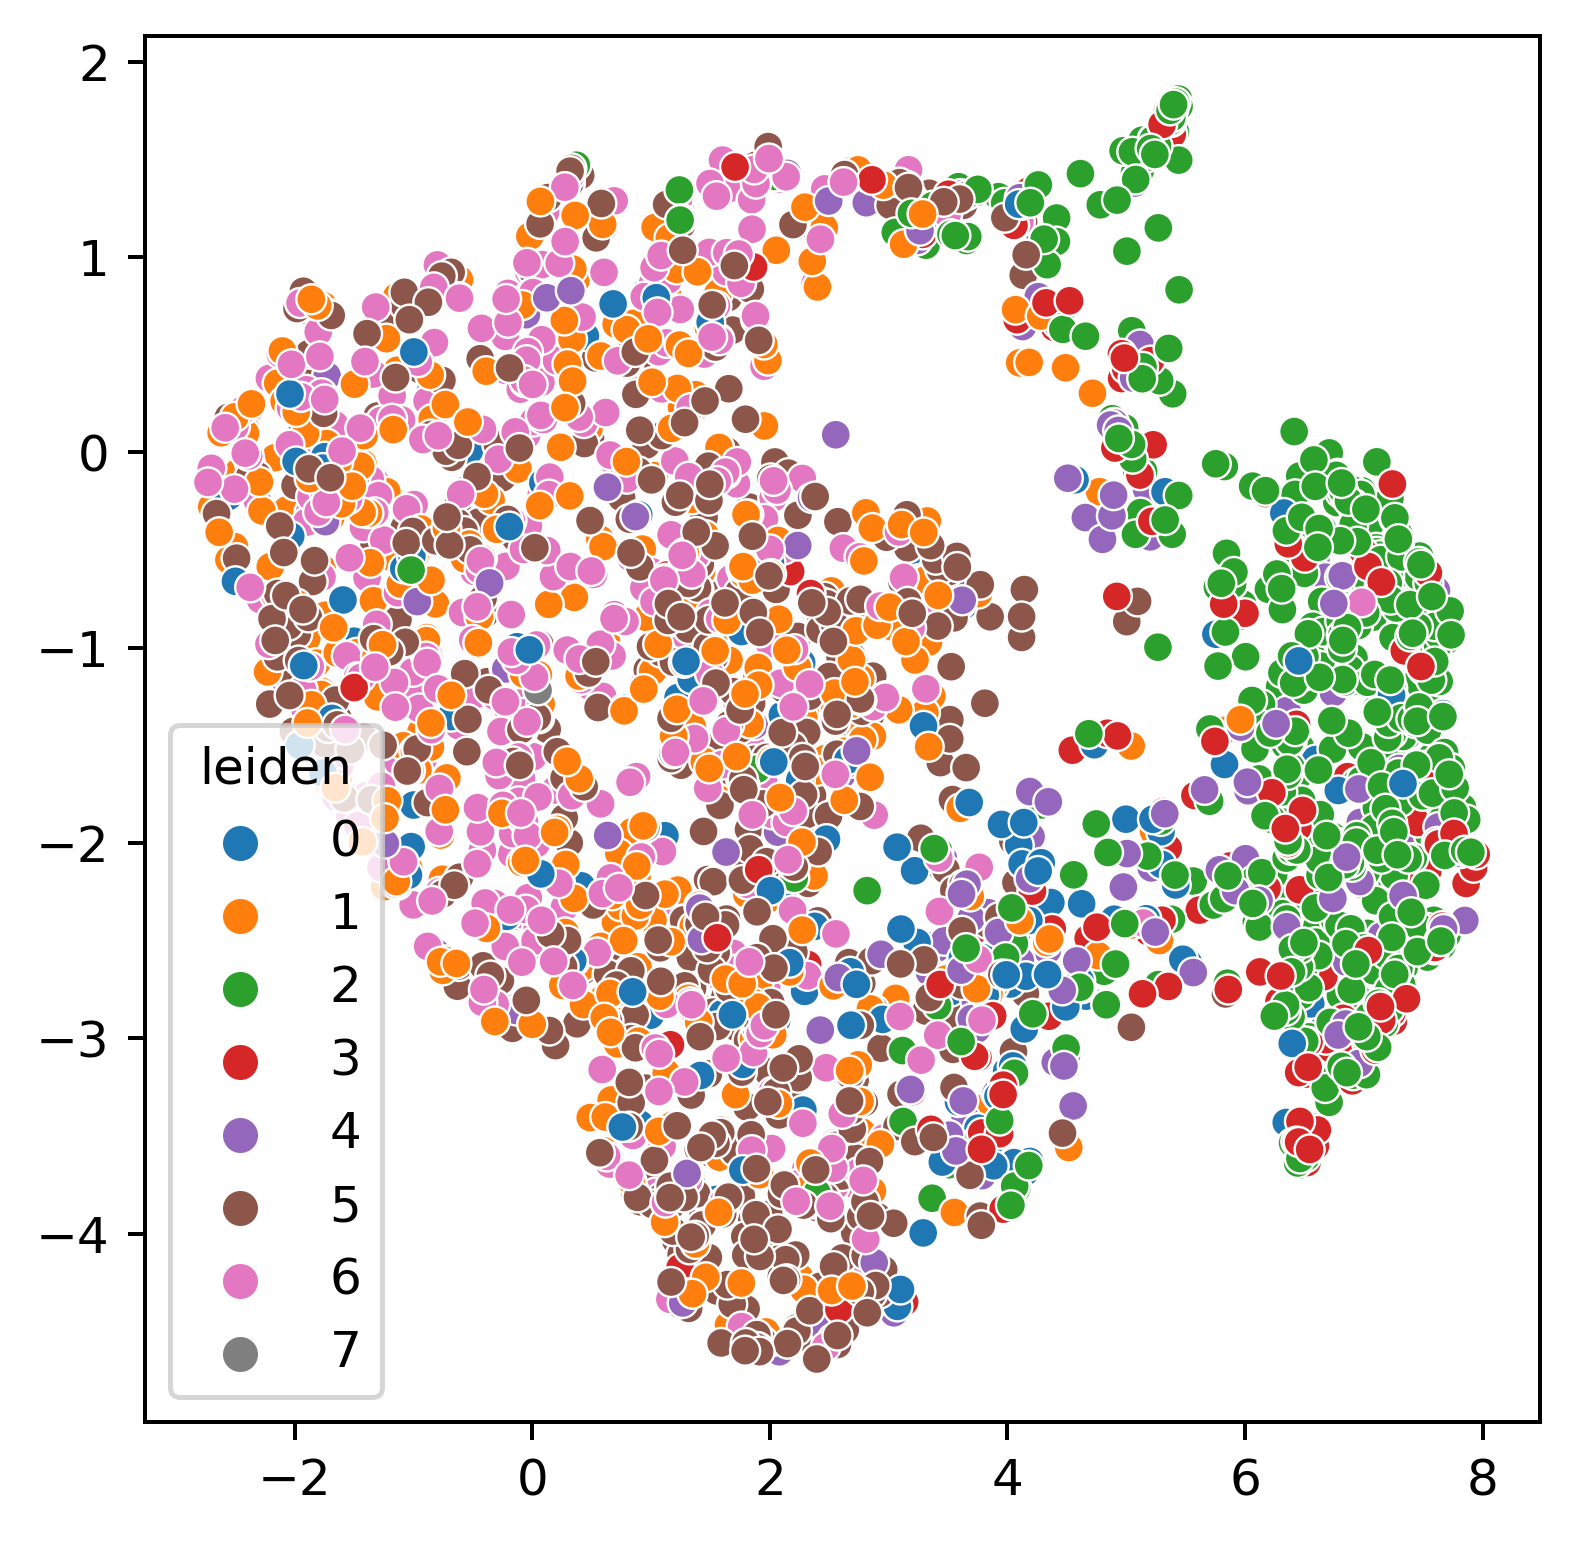

In [30]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=data.obs["leiden"])

<Axes: >

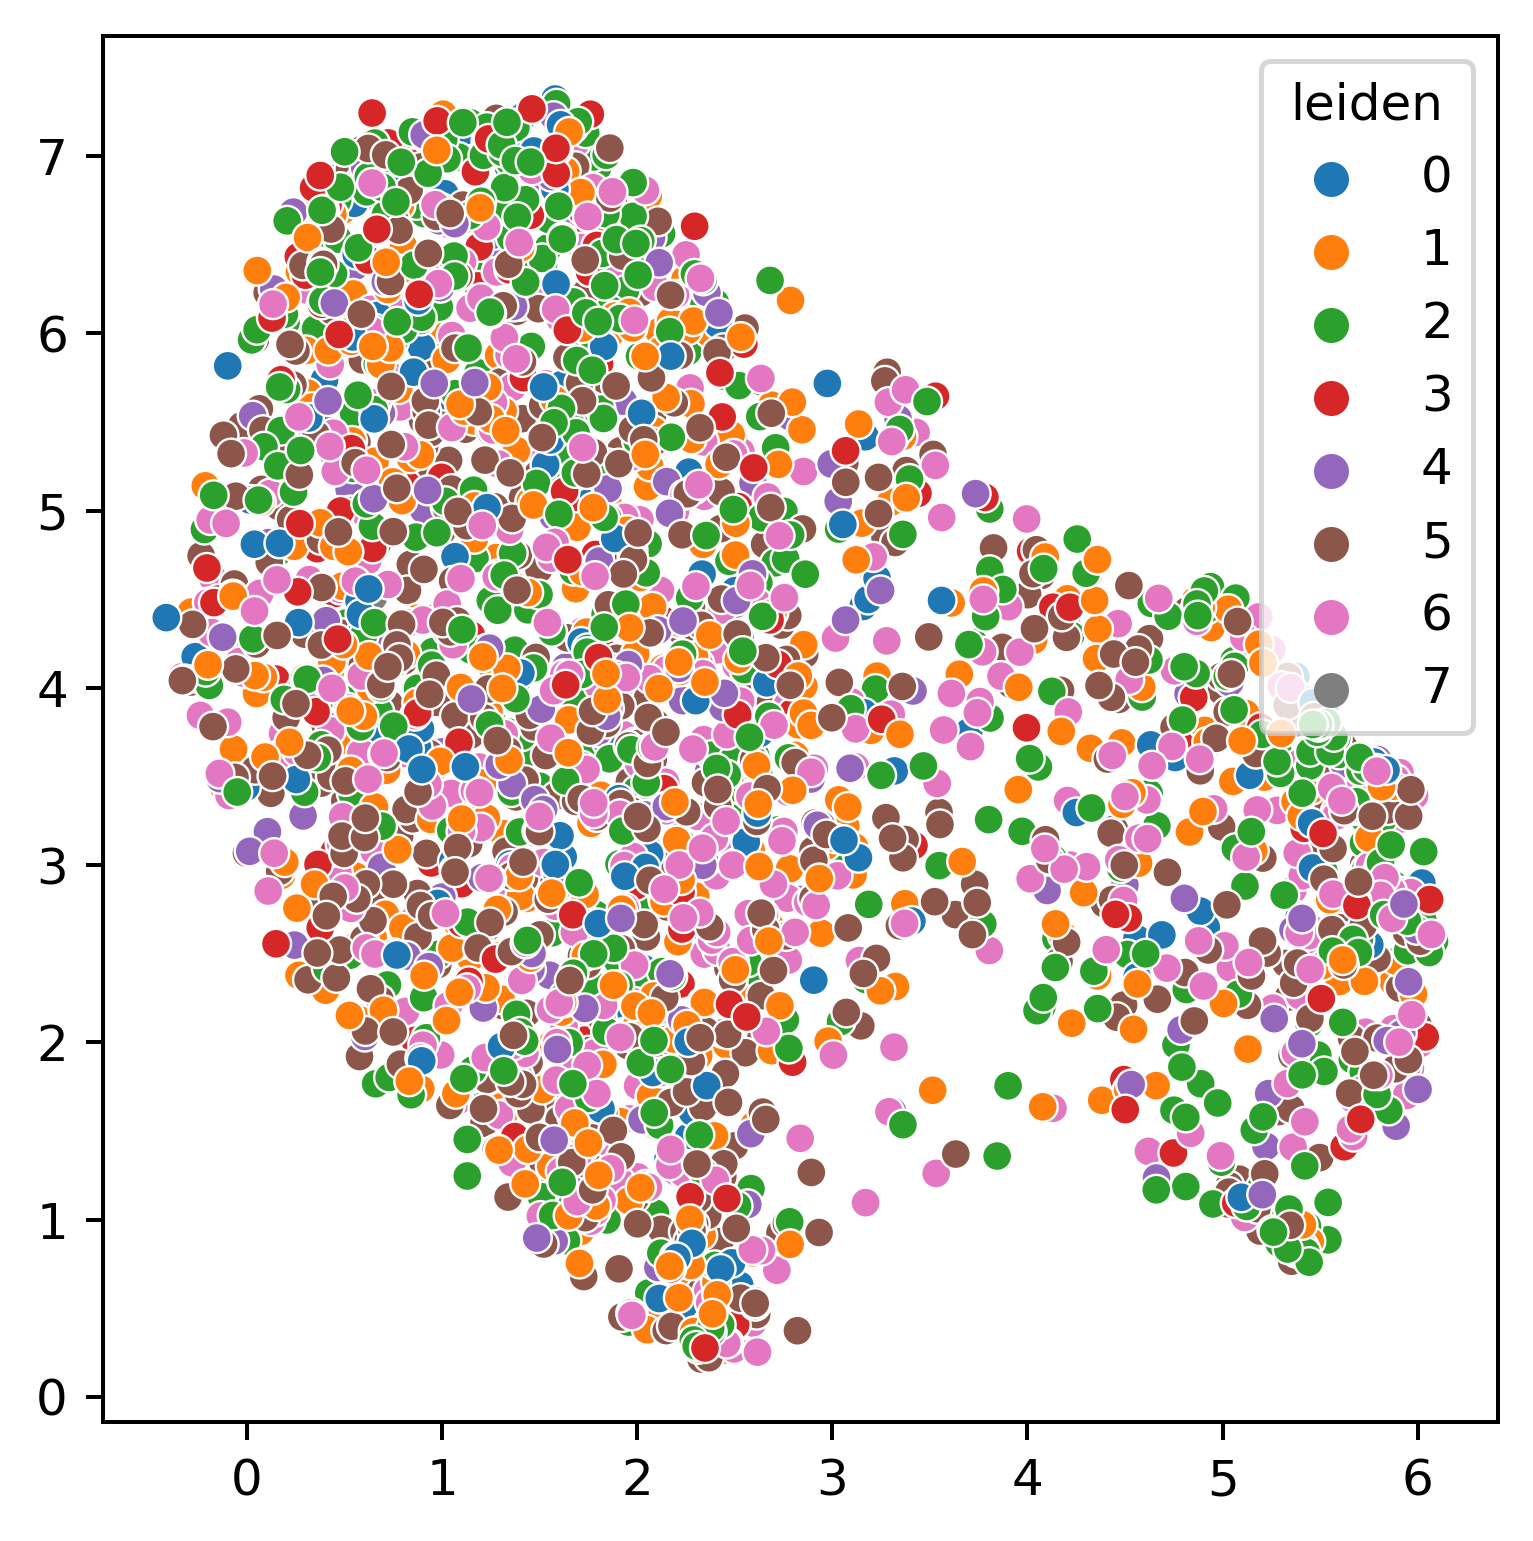

In [15]:
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=embedding_2[:, 0],
    y=embedding_2[:, 1],
    hue=data.obs["leiden"])